In [1]:
import sqlite3
import pandas as pd
import os
import json
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import re

In [2]:
# Connect to database
conn = sqlite3.connect("../../../databases/MLB_Betting.db")


# CREATING PANDAS DF FOR FEATURES

In [ ]:
# join query to get the season from each game as well 
join_query = """
SELECT 
    Features.game_id,
    OldGames.season,
    Features.features_json
FROM 
    Features
INNER JOIN 
    OldGames ON Features.game_id = OldGames.game_id
"""

df = pd.read_sql_query(join_query, conn)
# Convert features_json column from string to dict
df["features_json"] = df["features_json"].apply(json.loads)
# Expand the dict into new DataFrame columns
features_df = pd.json_normalize(df["features_json"])

# Concatenate with the game_id
df_final = pd.concat([df["game_id"], df["season"], features_df], axis=1)
df_final["season"] = df_final["season"].astype(int)

# Diff column code
diff_cols = []

# Get base stat names by stripping 'season_home_avg_' or 'rolling_home_avg_'
home_cols = [col for col in df_final.columns if re.match(r"(season|rolling)_home_avg_", col)]
for home_col in home_cols:
    # create the diff column
    diff_col = home_col.replace("_home", "") + "_diff" 
    away_col = home_col.replace("home", "away")

    # Calculate difference: home - away
    df_final[diff_col] = df_final[home_col] - df_final[away_col]
    diff_cols.append(diff_col)

# SPLITTING INTO TRAIN + TEST AND REMOVING NON NUMERIC FEATURES

In [4]:
# Train from 2015 to 2022
df_train = df_final[df_final["season"] <= 2022]

# Test on 2023 and 2024
df_test = df_final[df_final["season"] >= 2023]

# Target variable
Y_train = df_train["label"]
Y_test = df_test["label"]

# features
cols_to_drop = [col for col in df_final.columns if col not in diff_cols]

X_train = df_train.drop(columns=cols_to_drop)
X_test = df_test.drop(columns=cols_to_drop)
  
# OLD METHOD NO DIFFS
# X_train = df_train.drop(columns=["game_id", "home_team_id", "away_team_id", "season", "label"])
# X_test = df_test.drop(columns=["game_id", "home_team_id", "away_team_id", "season", "label"])

# Metadata (for tracking predictions later)
game_ids_train = df_train["game_id"]
game_ids_test = df_test["game_id"]

home_team_train = df_train["home_team_id"]
home_team_test = df_test["home_team_id"]

away_team_train = df_train["away_team_id"]
away_team_test = df_test["away_team_id"]


# LOGISTIC REGRESSION

Accuracy: 0.5583
Precision: 0.5593
Recall: 0.7420
F1 Score: 0.6378

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.36      0.43      2237
           1       0.56      0.74      0.64      2465

    accuracy                           0.56      4702
   macro avg       0.56      0.55      0.54      4702
weighted avg       0.56      0.56      0.54      4702

ROC AUC Score: 0.5818


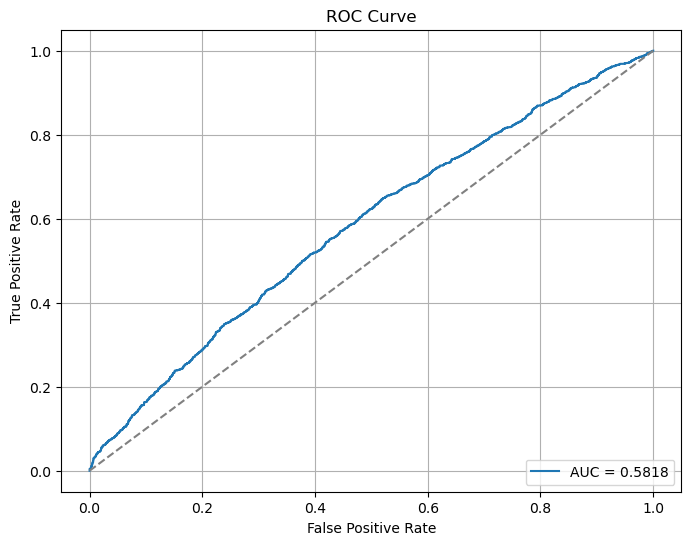

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, roc_curve
from sklearn.preprocessing import StandardScaler

# Scale for logistic regression because sensitive to scale

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# Initialize logistic regression model
logreg = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42) 
# Train the model
logreg.fit(X_train_scaled, Y_train)

# Predict on test set
y_pred = logreg.predict(X_test_scaled)
y_proba = logreg.predict_proba(X_test_scaled)[:, 1]  

# Calculate metrics
accuracy = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(Y_test, y_pred))

# Calculate AUC-ROC score
roc_auc = roc_auc_score(Y_test, y_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# XGBoost

In [7]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, roc_curve
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import matplotlib.pyplot as plt


# set scale_pos_weight for class imbalance
neg, pos = np.bincount(Y_train)
scale_pos_weight = neg / pos

# 2. Define parameter grid
param_grid = {
    'max_depth': [2, 3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 300, 500],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7, 0.9],
    'reg_alpha': [0, 0.5, 1.0],
    'reg_lambda': [1.0, 2.0]
}

# 3. Initialize XGBoost Classifier
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)

# 4. Cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 5. Grid Search
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    verbose=1,
    n_jobs=-1
)

# 6. Fit and get best model
grid_search.fit(X_train, Y_train)
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 864 candidates, totalling 4320 fits


/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:41:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:41:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:41:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/xgboost/training.py:183: UserW

KeyboardInterrupt: 

In [8]:

print(best_model)
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(Y_test, y_pred))

# Calculate AUC-ROC score
roc_auc = roc_auc_score(Y_test, y_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

NameError: name 'best_model' is not defined

/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


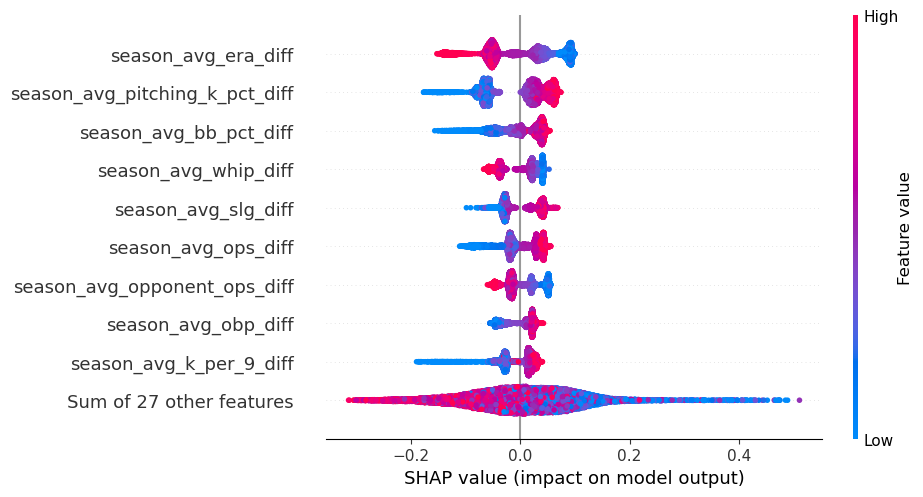

In [25]:
import shap
explainer = shap.Explainer(best_model)
shap_values = explainer(X_train)
shap.plots.beeswarm(shap_values)

# MLP

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   1.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   2.0s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   2.0s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   2.8s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   3.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   3.2s


/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   4.9s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   4.9s


/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   5.1s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   5.1s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   5.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   5.3s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   4.1s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   3.3s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   3.8s


/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   7.9s


/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   8.2s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   7.4s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   5.9s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   4.3s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   7.0s


/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   7.6s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   7.5s


/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   8.9s


/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=  12.0s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=  11.7s


/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=  11.1s


/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=  11.2s


/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=  11.9s


/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=  11.0s


/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=  10.9s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=  11.8s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   1.8s
[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=  11.7s


/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=  11.5s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   1.8s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   3.9s


/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=  10.8s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   1.6s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   4.1s


/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   4.5s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   2.4s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   2.5s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   2.5s


/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   4.1s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   4.0s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   3.9s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   2.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   2.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   3.4s


/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=  10.3s


/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   5.8s


/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   6.0s


/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   7.6s


/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   6.1s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   4.3s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   5.4s


/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   5.7s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   4.7s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   5.9s


/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=  10.1s


/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=  10.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   9.4s


/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=  10.1s


/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   9.7s


/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   9.7s


/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=   9.6s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=   9.7s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   1.0s


/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=  10.2s
[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=  10.4s


/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=  10.3s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   1.6s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   1.3s


/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   4.0s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   4.1s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   3.8s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   2.4s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   2.1s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   1.4s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   2.8s


/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   3.8s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   4.0s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   1.1s


/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   4.0s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   1.6s


/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=  10.7s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   3.2s


/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   6.5s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   3.9s


/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   6.5s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   6.5s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   4.4s


/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   6.5s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   6.5s


/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   6.6s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   4.0s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   5.2s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   5.9s


/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=  11.4s


/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   4.7s


/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=  11.5s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   4.5s


/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=  11.4s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   1.9s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   1.1s


/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=  11.6s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   1.3s


/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=  11.7s


/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   4.5s


/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=  11.0s


/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=  11.7s
[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=  11.0s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   2.1s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   2.1s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   2.6s


/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.0001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=  10.9s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   1.7s


/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   4.5s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   1.6s


/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   4.8s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=sgd; total time=   2.6s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   5.4s


/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   3.6s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   6.6s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   3.9s


/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   6.9s


/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=constant, solver=adam; total time=   6.8s


/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   6.5s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=sgd; total time=   4.9s


/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   6.8s


/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100,), learning_rate=adaptive, solver=adam; total time=   6.7s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   4.7s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   6.7s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=sgd; total time=   8.2s


/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=  11.1s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=   6.1s


/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=  11.2s


/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=constant, solver=adam; total time=  10.6s


/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=  10.1s


/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/envs/MLB_Betting/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=   9.7s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=   9.2s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=adam; total time=   9.5s
[CV] END activation=tanh, alpha=0.001, hidden_layer_sizes=(100, 50), learning_rate=adaptive, solver=sgd; total time=   7.3s
Best params: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'sgd'}
Accuracy: 0.5549
Precision: 0.5579
Recall: 0.7274
F1 Score: 0.6314

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.36      0.44      2237
           1       0.56      0.73      0.63      2465

    accuracy                           0.55      4702
   macro avg       0.55      0.55      0.53      4702
weighted av

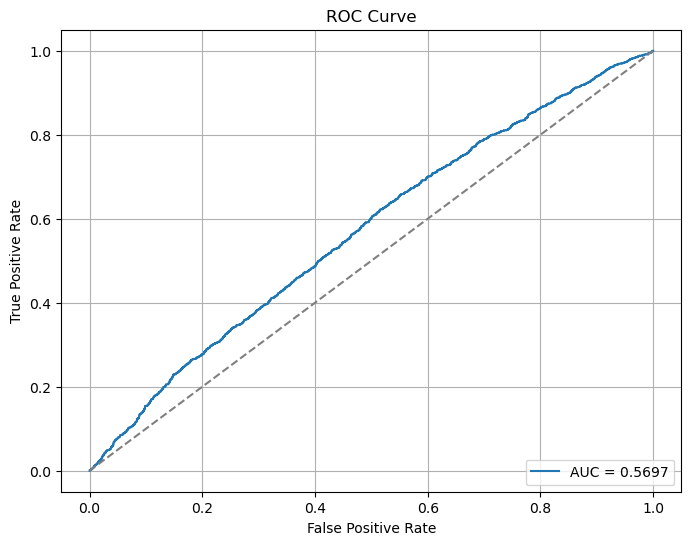

In [7]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold

mlp = MLPClassifier(max_iter=200)

# Define the hyperparameter grid you want to search over
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001],  # L2 penalty (regularization term)
    'learning_rate': ['constant', 'adaptive']
}

# Set up GridSearchCV
grid_search = GridSearchCV(mlp, param_grid, cv=3, n_jobs=-1, verbose=2)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# Fit to your training data
grid_search.fit(X_train_scaled, Y_train)

# Best params & best estimator
print("Best params:", grid_search.best_params_)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)
y_proba = best_model.predict_proba(X_test_scaled)[:, 1]  

accuracy = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(Y_test, y_pred))

# Calculate AUC-ROC score
roc_auc = roc_auc_score(Y_test, y_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()